# Using tree sequences for pop gen inference

Tree sequences are efficient, easy to deal with, and potentially very informative for inference of demographic events. By using spatial relationships (eg RF distance) along the sequence as predictive features we may be able to better infer demographic events even when using inferred trees.

In [15]:
import msprime
from IPython.display import SVG
import dendropy
from dendropy.calculate.treecompare import symmetric_difference
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import ete3

Running replicates https://tskit.dev/msprime/docs/stable/replication.html#sec-randomness-replication

In [27]:
#Simulate 200 reps
L=1e6
N= 10000
n_reps = 200

#Neut
neut_reps = msprime.sim_ancestry(
    1000, 
    recombination_rate=1e-8, 
    sequence_length=L, 
    ploidy=1, 
    population_size=N, 
    num_replicates=n_reps)

neut_mts = [msprime.sim_mutations(ts, rate=1e-8) for ts in neut_reps]

for idx, ts in enumerate(neut_mts):
    ts.dump(f"treeseqs/neut/{idx}.trees")

print("Done with neuts")

#Hard sweep
sweep_model = msprime.SweepGenicSelection(
    position=L / 2,  # beneficial mutation location: middle of chrom
    start_frequency=1.0 / (2 * N), # starting frequency of the sweeping mutation
    end_frequency=0.99, # final frequency of the mutation (incomplete sweep)
    s=0.25, # selection coefficient of the beneficial mutation
    dt=1e-6, # nevermind this!
)

sweep_reps = msprime.sim_ancestry(
    1000,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=N,
    recombination_rate=1e-8,
    sequence_length=L,
    ploidy=1,
    num_replicates=n_reps
)

sweep_mts = [msprime.sim_mutations(ts, rate=1e-8) for ts in sweep_reps]

for idx, ts in enumerate(sweep_mts):
    ts.dump(f"treeseqs/sweep/{idx}.trees")

print("Done with sweeps")

Done with neuts
Done with sweeps


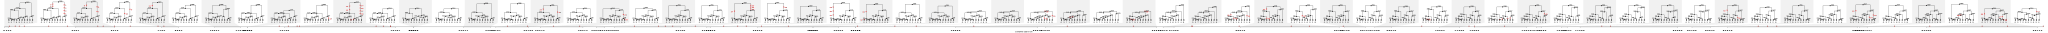

In [28]:
SVG(neut_mts[0].simplify(range(10)).draw_svg(time_scale="rank", x_lim=(0, 100000)))


In [ ]:
def get_middle_win(iterable, k=51):
    """Given a list/iterable and window size get middle"""
    center_idx = int(len(iterable)/2)
    half_win = int(k/2)

    return range(center_idx - half_win, center_idx + half_win)

In [23]:
#Read in trees to ete3 through newick conversion, calc RFs while in memory, move on to next
neut_reps_rfs = []
sweep_reps_rfs = []
for neut_rep, sweep_rep in zip(neut_mts, sweep_mts):
    neut_trees = neut_rep.simplify().as_newick(include_alignments=False)
        neut_nw = 
    neut_ete = ete3.Tree(neut_nw)

    sweep_nw = sweep_rep.simplify().as_newick(include_alignments=False)

AttributeError: 'TreeSequence' object has no attribute 'as_newick'

In [ ]:
#RF Dist Stats
neut_arr = np.array(neut_rfs)
sweep_arr = np.array(sweep_rfs)

neut_df = pd.DataFrame(neut_arr)
sweep_df = pd.DataFrame(sweep_arr)

print("Neutral")
print(neut_df.describe())

print("\nSweep")
print(sweep_df.describe())

Neutral
               0
count  16.000000
mean    9.375000
std    12.279387
min     0.000000
25%     0.000000
50%     5.000000
75%    10.500000
max    40.000000

Sweep
             0
count  5.00000
mean   1.60000
std    1.67332
min    0.00000
25%    0.00000
50%    2.00000
75%    2.00000
max    4.00000


<AxesSubplot:title={'center':'Sweep RF Dists'}, xlabel='Tree Pair Index', ylabel='RF Distance'>

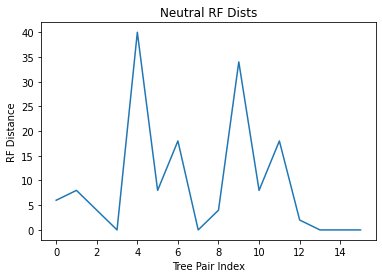

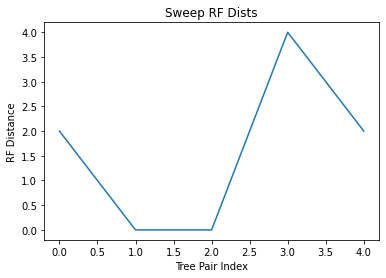

In [ ]:
#Plot location-based RF
neut_df.plot(title="Neutral RF Dists", ylabel="RF Distance", xlabel="Tree Pair Index", legend=None)
sweep_df.plot(title="Sweep RF Dists", ylabel="RF Distance", xlabel="Tree Pair Index", legend=None)

